In [1]:
import os

os.environ['ARCHITECTURE'] = 'convnext'
os.environ['TILE_SIZE'] = '50'
os.environ['BATCH_SIZE'] = '50'
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

In [2]:
from ray.tune import ResultGrid, ExperimentAnalysis, Result
from landnet.config import (
    MODELS_DIR,
    FIGURES_DIR,
    PROCESSED_DATA_DIR,
    BATCH_SIZE,
    TILE_SIZE,
)
from landnet.modelling.tune import MetricSorter
from landnet.modelling.classification.inference import InferTrainTest
from landnet.modelling.classification.stats import (
    BinaryClassificationMetricCollection,
)
from landnet.features.tiles import TileConfig, TileSize
from landnet.enums import GeomorphometricalVariable, Mode
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import geopandas as gpd
import numpy as np
import torch
import re
import shutil

In [ ]:
TRIAL_NAME = '5cbdad8ab41a4deeba4fe764c9cc2064'
METRIC = MetricSorter('val_f2_score', 'max')
MULTIVARIATE = re.compile(r'\d+_variables')

In [ ]:
def fix_missing_predictions(
    variables: list[GeomorphometricalVariable],
    best_checkpoint_path: Path,
):
    infer = InferTrainTest(
        variables=variables, out_dir=best_checkpoint_path.parent / 'predictions'
    )
    tune_space = {
        'batch_size': BATCH_SIZE,
        'tile_config': TileConfig(TileSize(TILE_SIZE, TILE_SIZE), overlap=0),
    }
    infer.handle_checkpoint(
        best_checkpoint_path,
        tune_space,
        modes=(Mode.TRAIN, Mode.TEST, Mode.VALIDATION),
    )


def get_results_from_checkpoint_dir(checkpoint_dir: Path):
    predictions = checkpoint_dir / 'predictions'

    all_metrics = {}
    map_ = {}
    for mode in (Mode.TRAIN, Mode.TEST, Mode.VALIDATION):
        metrics = pd.read_csv(
            predictions / mode.value / 'metrics.csv', index_col=0
        )
        metrics = metrics.iloc[:, 0]
        metrics.index = map_.get(mode, mode.value) + '_' + metrics.index
        all_metrics.update(metrics.to_dict())
    return all_metrics


def parse_variables_from_config(config_path: Path):
    with open(config_path, 'r') as f:
        config = f.read().splitlines()
    variables = []
    for var in config:
        parsed = var.split('.')[1]
        variables.append(GeomorphometricalVariable._member_map_[parsed])
    return variables


def check_trial_errors(experiment_dir: Path) -> list[Result]:
    errored_results: list[Result] = []
    for file in experiment_dir.iterdir():
        if not file.is_dir():
            continue
        result = Result.from_path(file)

        if result.error is not None:
            errored_results.append(result)
    return errored_results

In [ ]:
experiments = []
experiments_dir = MODELS_DIR / TRIAL_NAME
best_results = []
for experiment_dir in experiments_dir.iterdir():
    if not experiment_dir.is_dir():
        continue
    errored_results: list[Result] = check_trial_errors(experiment_dir)
    if errored_results:
        raise Exception('Found errored results:', errored_results)

    experiment = ExperimentAnalysis(
        experiment_dir, default_metric=METRIC.metric, default_mode=METRIC.mode
    )
    result = ResultGrid(experiment).get_best_result(
        metric=METRIC.metric, mode=METRIC.mode, scope='all'
    )
    best_results.append(result)
    result_config = result.config.copy()
    result_config['variable'] = experiment_dir.stem
    result_path = Path(result.path)
    checkpoint_path = Path(
        result.get_best_checkpoint(metric=METRIC.metric, mode=METRIC.mode).path
    )
    variables = parse_variables_from_config(
        Path(experiment.experiment_path) / 'geomorphometrical_variables'
    )
    if all(
        (checkpoint_path / 'predictions' / mode.value).exists()
        for mode in (Mode.VALIDATION, Mode.TEST, Mode.TRAIN)
    ):
        print('computing for', result_path)
        assert checkpoint_path
        fix_missing_predictions(
            variables,
            checkpoint_path / 'checkpoint.ckpt',
        )
        print('computed for', result_path, 'checkpoint', checkpoint_path)
    result_config.update(get_results_from_checkpoint_dir(checkpoint_path))
    result_config.update(result_config['train_loop_config'])
    result_config['checkpoint'] = checkpoint_path.name
    result_config['epoch'] = int(checkpoint_path.name.split('_')[1])
    experiments.append(result_config)
experiments = pd.DataFrame(experiments)
mask = experiments['variable'].str.fullmatch(MULTIVARIATE)
experiments[mask].to_csv(
    experiments_dir / 'results_multivariate.csv', index=False
)
experiments[~mask].to_csv(experiments_dir / 'results.csv', index=False)

In [12]:
type_ = 'validation'
df_sorted = experiments[
    ['variable', 'checkpoint', f'{type_}_f2_score', 'train_loop_config']
].sort_values(f'{type_}_f2_score', ascending=False)
# df_sorted[~df_sorted['variable'].str.contains('_variables')][:60]
df_sorted.head(15)

,variable,checkpoint,validation_f2_score,train_loop_config
10,18_variables,checkpoint_000007,0.933314,"{'learning_rate': 2.5349719516414e-05, 'batch_..."
6,14_variables,checkpoint_000009,0.932591,"{'learning_rate': 3.146057909839248e-05, 'batc..."
23,30_variables,checkpoint_000004,0.932591,"{'learning_rate': 3.146057909839248e-05, 'batc..."
30,3_variables,checkpoint_000008,0.930462,"{'learning_rate': 3.146057909839248e-05, 'batc..."
54,9_variables,checkpoint_000007,0.929267,"{'learning_rate': 2.5349719516414e-05, 'batch_..."
2,10_variables,checkpoint_000008,0.928837,"{'learning_rate': 2.5349719516414e-05, 'batch_..."
20,28_variables,checkpoint_000005,0.928837,"{'learning_rate': 3.146057909839248e-05, 'batc..."
31,4_variables,checkpoint_000006,0.928652,"{'learning_rate': 1.4604695734325494e-05, 'bat..."
29,36_variables,checkpoint_000009,0.928531,"{'learning_rate': 3.146057909839248e-05, 'batc..."
12,20_variables,checkpoint_000009,0.928408,"{'learning_rate': 3.146057909839248e-05, 'batc..."


/tmp/ipykernel_277603/730846976.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['experiment'] = (


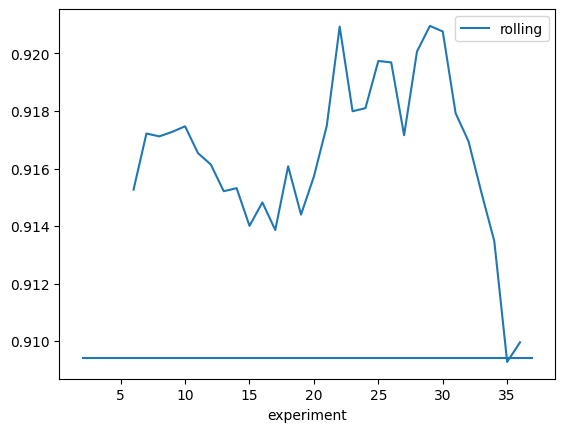

In [13]:
subset = df_sorted.loc[df_sorted['variable'].str.fullmatch(MULTIVARIATE)]
subset['experiment'] = (
    subset['variable'].str.replace('_variables', '').astype(int)
)
# subset = subset.loc[subset['experiment'].mod(5) == 0]
vals = subset.sort_values(by='experiment')
vals['rolling'] = vals['test_f2_score'].rolling(5).mean()
vals.plot(x='experiment', y='rolling', kind='line')
plt.hlines(0.909405, 2, 37)

     variable        metric     value
0        area  val_f2_score  0.927691
1       slope  val_f2_score  0.924523
2         tri  val_f2_score  0.918743
3       shade  val_f2_score  0.917210
4       clong  val_f2_score  0.916403
5         cup  val_f2_score  0.915690
6       cgene  val_f2_score  0.912933
7       cmaxi  val_f2_score  0.912125
8        poso  val_f2_score  0.910987
9         cdl  val_f2_score  0.910494
10        tpi  val_f2_score  0.910364
11      cprof  val_f2_score  0.909850
12       nego  val_f2_score  0.909091
13        clo  val_f2_score  0.906670
14       wind  val_f2_score  0.905490
15        vld  val_f2_score  0.905099
16        clu  val_f2_score  0.901090
17        cbl  val_f2_score  0.900168
18      cmini  val_f2_score  0.898783
19        vrm  val_f2_score  0.898481
20  northness  val_f2_score  0.898032
21      croto  val_f2_score  0.896240
22        cdo  val_f2_score  0.888318
23        ioc  val_f2_score  0.887452
24        twi  val_f2_score  0.884944
25      ctan

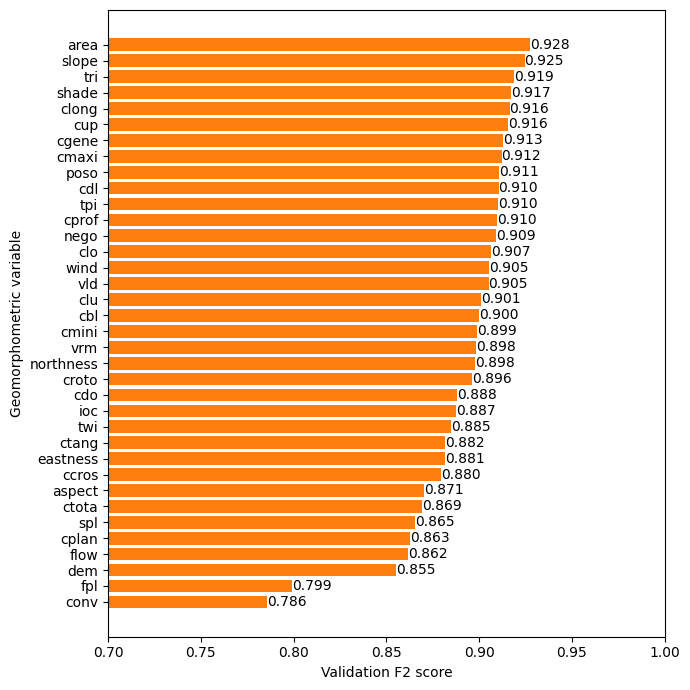

In [58]:
long_df = (
    experiments[~experiments['variable'].str.fullmatch(MULTIVARIATE)]
    .melt(
        id_vars='variable',
        value_vars=['val_f2_score'],
        var_name='metric',
        value_name='value',
    )
    .sort_values('value', ascending=False)
    .reset_index(drop=True)
)
print(long_df)
fig, ax = plt.subplots(figsize=(7, 7))
sns.barplot(
    long_df,
    x='value',
    y='variable',
    # hue='metric',
    orient='y',
    ax=ax,
)
y_pos = np.arange(long_df['variable'].shape[0])

hbars = ax.barh(
    y_pos,
    long_df['value'].values.flatten(),
    align='center',
)
ax.bar_label(hbars, fmt='%.3f')
ax.set_xlabel('Validation F2 score')
ax.set_ylabel('Geomorphometric variable')
ax.set_xlim(0.7, 1)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'geomorphometric_variable_metrics.png', dpi=300)

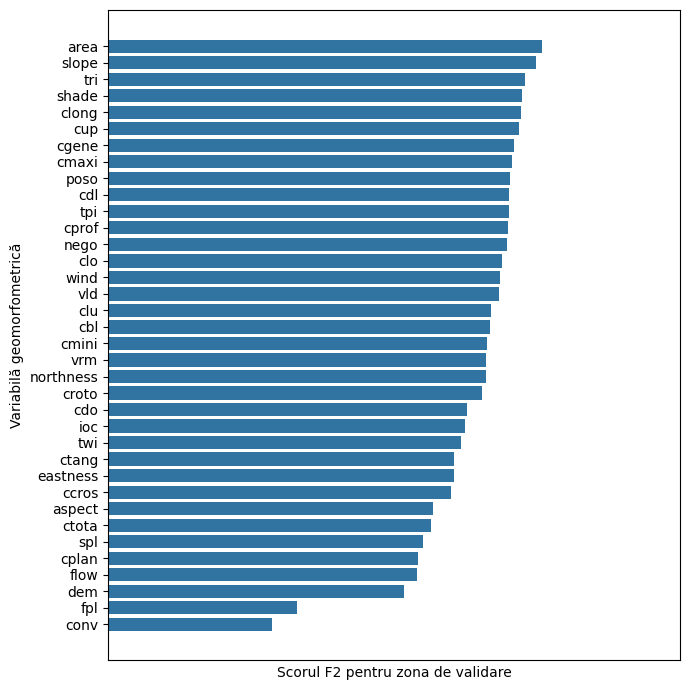

In [50]:
fig, ax = plt.subplots(figsize=(7, 7))

sns.barplot(
    long_df,
    x='value',
    y='variable',
    # hue='metric',
    orient='y',
    ax=ax,
)
ax.set_xlim(0.7, 1)
ax.set_xlabel('Scorul F2 pentru zona de validare')
ax.set_ylabel('Variabilă geomorfometrică')
# Label with specially formatted floats
y_pos = np.arange(long_df['variable'].shape[0])

hbars = ax.barh(
    y_pos,
    long_df['metric'].values.flatten(),
    align='center',
)


ax.bar_label(hbars, fmt='%.3f')

plt.tight_layout()
plt.savefig(FIGURES_DIR.parent / 'val_f2_score.png', dpi=300)


# Scores all areas, not just split by train, test, validation

In [30]:
def handle_tiles_directory(directory: Path):
    tiles = gpd.read_file(directory / 'tiles.fgb')
    logits = tiles['logits']
    y = tiles['y']
    return (torch.from_numpy(logits.values), torch.from_numpy(y.values))


def compute_metrics(logits, target):
    metrics = BinaryClassificationMetricCollection()
    metrics.update(logits, target)
    computed = metrics.compute()
    for k, v in computed.items():
        if isinstance(v, torch.Tensor):
            computed[k] = v.item()
    return computed


def handle_result(result: Result, mode=None):
    directory = (
        Path(result.get_best_checkpoint(METRIC.metric, METRIC.mode).path)
        / 'predictions'
    )
    logits = torch.Tensor()
    targets = torch.Tensor()
    for m in (Mode.TRAIN, Mode.TEST, Mode.VALIDATION):
        if mode is not None:
            if m is not mode:
                continue
        vals = handle_tiles_directory(directory / m.value)
        logits = torch.concatenate([logits, vals[0]])
        targets = torch.concatenate([targets, vals[1]])

    metrics = compute_metrics(logits, targets)
    name = directory.parent.parent.stem
    metrics['name'] = name
    metrics['path'] = directory
    return metrics


results = []
for result in best_results:
    result = handle_result(result)
    results.append(result)
results_df = pd.DataFrame(results)
results_df.set_index('name', inplace=True)
results_train = []
for result in best_results:
    result = handle_result(result, Mode.TRAIN)
    results_train.append(result)
results_train = pd.DataFrame(results_train)
results_train.set_index('name', inplace=True)
results_test = []
for result in best_results:
    result = handle_result(result, Mode.TEST)
    results_test.append(result)
results_test = pd.DataFrame(results_test)
results_test.set_index('name', inplace=True)
results_validation = []
for result in best_results:
    result = handle_result(result, Mode.VALIDATION)
    results_validation.append(result)
results_validation = pd.DataFrame(results_validation)
results_validation.set_index('name', inplace=True)

In [31]:
if 'f2_score_train' not in results_test.columns:
    results_test = results_test.merge(
        results_train,
        left_index=True,
        right_index=True,
        suffixes=(None, '_train'),
    )
results_test = results_test.sort_values(
    by=['f2_score', 'f2_score_train'],
    ascending=False,
)
results_test.to_csv(
    PROCESSED_DATA_DIR / f'{TRIAL_NAME}_results_for_test_areas.csv'
)

In [32]:
results_train = results_train.sort_values(
    by=['f2_score', 'sensitivity'],
    ascending=False,
)
results_train.to_csv(
    PROCESSED_DATA_DIR / f'{TRIAL_NAME}_results_for_train_areas.csv'
)

In [33]:
results_validation = results_validation.sort_values(
    by=['f2_score', 'sensitivity'],
    ascending=False,
)
results_validation.to_csv(
    PROCESSED_DATA_DIR / f'{TRIAL_NAME}_results_for_validation_areas.csv'
)

In [34]:
if 'f2_score_test' not in results_df.columns:
    results_df = results_df.merge(
        results_train,
        left_index=True,
        right_index=True,
        suffixes=(None, '_test'),
    )
results_df = results_df.sort_values(
    by=['f2_score', 'f2_score_test'],
    ascending=False,
)
results_df.to_csv(
    PROCESSED_DATA_DIR / f'{TRIAL_NAME}_results_for_all_areas.csv'
)